In [ ]:
!pip3 install albumentations
!pip install torchvision

     |████████████████████████████████| 634kB 17.6MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=503b02f9749d43f673879229643485f7062606afd8bd63eb6b49719799187f55
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [ ]:
%matplotlib inline
from pylab import *
import cv2
import torch
from utils import cuda
from albumentations import Compose, Normalize
from albumentations.pytorch.functional import img_to_tensor
from dataset_ft import load_image
from dataset_ft import load_mask
from generate_masks import get_model

In [ ]:
rcParams['figure.figsize'] = 10, 10

In [ ]:
def img_transform(p=1):
    return Compose([
        Normalize(p=1)
    ], p=p)

def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

# UNet, UNet11 and LinkNet34 models

## Load models


In [ ]:
model_ent_path = 'data/models_ft/unet_binary_20/model_0_ent_5.pt'
model_ent = get_model(model_ent_path, model_type='UNet', problem_type='binary')

model_path = 'data/models/unet_binary_20/model_0.pt'
model = get_model(model_path, model_type='UNet', problem_type='binary')

model_11_ent_path = 'data/models_ft/unet11_binary_20/model_0_ent_4.pt'
model_11_ent = get_model(model_11_ent_path, model_type='UNet11', problem_type='binary')

model_11_path = 'data/models/unet11_binary_20/model_0.pt'
model_11 = get_model(model_11_path, model_type='UNet11', problem_type='binary')


## Compute segmentation

(1184, 1024, 3)


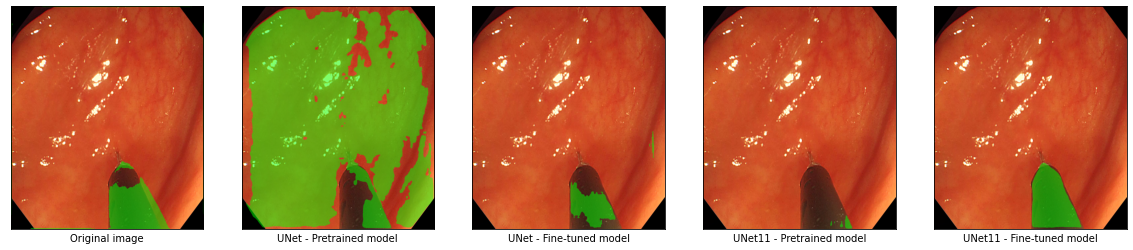

UNet : 0.13232922554016113
UNet11 : 0.20279145240783691


In [ ]:
import time

img_file_name = 'toolSegmentation/images/img_40_raw.png'
img = load_image(img_file_name)
#image = img
# Image size has to be multiple of 32
#image = cv2.resize(img, dsize=(1024,1184), interpolation=cv2.INTER_CUBIC)
if (img.shape == (1080,1920,3)):
    image = img[24:,640:,:]
    mask = ground_truth[24:,640:]
elif (img.shape == (1056,1920,3)):
      image = img[:,640:,:]
      mask = ground_truth[:,640:]
else:
      image = img
      mask = ground_truth
#image = img[:,640:,:]
print(image.shape)
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)

ground_truth = load_mask(img_file_name,'binary')
#print(ground_truth.shape)
#mask = ground_truth
#mask = cv2.resize(ground_truth, dsize=(1024,1184), interpolation=cv2.INTER_CUBIC)
#mask = ground_truth[:,640:]

plt.figure(figsize=(20,20))

plt.subplot(151) # Original image
plt.xticks([])
plt.yticks([])
plt.grid(False)
imshow(mask_overlay(image, (mask > 0).astype(np.uint8)))
plt.xlabel('Original image')

plt.subplot(152) # Model UNet before training
mask_before = model(input_image)
mask_b = mask_before.data[0].cpu().numpy()[0]
plt.xticks([])
plt.yticks([])
plt.grid(False)
imshow(mask_overlay(image, (mask_b > 0).astype(np.uint8)))
plt.xlabel('UNet - Pretrained model')

plt.subplot(153) # UNet Trained model
t = time.time()
mask_after = model_ent(input_image)
mask_a = mask_after.data[0].cpu().numpy()[0]
elapsed = time.time() - t
plt.xticks([])
plt.yticks([])
plt.grid(False)
imshow(mask_overlay(image, (mask_a > 0).astype(np.uint8)))
plt.xlabel('UNet - Fine-tuned model')


plt.subplot(154) # Model UNet11 before training
mask_before_11 = model_11(input_image)
mask_b_11 = mask_before_11.data[0].cpu().numpy()[0]
plt.xticks([])
plt.yticks([])
plt.grid(False)
imshow(mask_overlay(image, (mask_b_11 > 0).astype(np.uint8)))
plt.xlabel('UNet11 - Pretrained model')

plt.subplot(155) # UNet11 Trained model
t_11 = time.time()
mask_after_11 = model_11_ent(input_image)
mask_a_11 = mask_after_11.data[0].cpu().numpy()[0]
elapsed_11 = time.time() - t_11
plt.xticks([])
plt.yticks([])
plt.grid(False)
imshow(mask_overlay(image, (mask_a_11 > 0).astype(np.uint8)))
plt.xlabel('UNet11 - Fine-tuned model')
#plt.savefig('results_2425.png')
plt.show()

print("UNet : " + str(elapsed))
print("UNet11 : " + str(elapsed_11))


## Evaluate models for one image

In [ ]:
from evaluate import jaccard, dice

iou_0_b = jaccard(mask>0,mask_b>0)
dice_0_b = dice(mask>0,mask_b>0)

iou_0_a = jaccard(mask>0,mask_a>0)
dice_0_a = dice(mask>0,mask_a>0)

iou_11_b = jaccard(mask>0,mask_b_11>0)
dice_11_b = dice(mask>0,mask_b_11>0)

iou_11_a = jaccard(mask>0,mask_a_11>0)
dice_11_a = dice(mask>0,mask_a_11>0)

print("iou UNet before : "+str(iou_0_b))
print("iou UNet after : "+str(iou_0_a))

print("dice UNet before : "+str(dice_0_b))
print("dice UNet after: "+str(dice_0_a))

print("iou UNet11 before : "+str(iou_11_b))
print("iou UNet11 after : "+str(iou_11_a))

print("dice UNet11 before: "+str(dice_11_b))
print("dice UNet11 after: "+str(dice_11_a))

iou UNet before : 0.025050878320479864
iou UNet after : 0.39789291750861006
dice UNet before : 0.04887733643333899
dice UNet after: 0.5692752463725954
iou UNet11 before : 0.02742834911165867
iou UNet11 after : 0.5356181450087877
dice UNet11 before: 0.05339223729883244
dice UNet11 after: 0.6975928836862274


# MiniNet


## Load model

In [ ]:
import utils_mininet.Loader as Loader
from utils_mininet.utils import get_params, preprocess, lr_decay, convert_to_tensors, restore_state, apply_augmentation, get_metrics,init_model
import nets.MiniNetv2 as MiniNetv2
import tensorflow as tf
import time
from evaluate import jaccard, dice
import glob
import numpy as np
import os
import cv2

In [ ]:
model = MiniNetv2.MiniNetv2(num_classes=2,include_top=True)
restore_state(model, colab_path + '/models_ft/mininet/model_0')

## Compute segmentation

In [ ]:
img_file_name = 'toolSegmentation/images/img_40_class.png'

file_path = img_file_name.replace('class','raw')

img = tf.keras.preprocessing.image.load_img(file_path,0)
img1 = tf.keras.preprocessing.image.img_to_array(img).astype(np.float32)
input_img = np.expand_dims(img1,0)

gt = tf.keras.preprocessing.image.load_img(img_file_name,0)
gt = gt.convert(mode="L")
gt = np.asarray(gt)

if (input_img.shape == (1,1080,1920,3)):
  image = input_img[:,24:,640:,:]
  mask = gt[24:,640:]
elif (input_img.shape == (1,1056,1920,3)):
    image = input_img[:,:,640:,:]
    mask = gt[:,640:]
else:
    image = input_img
    mask = gt

mask_pre = model(image)
mask_pre = np.asarray(mask_pre)
mask_pre = mask_pre.squeeze(0)
mask_pre = mask_pre[:,:,1]

print(img1.shape)
print(mask_pre.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(img)
plt.imshow(mask_pre>np.mean(mask_pre), alpha=0.5)
imshow(mask_overlay(img1[:,640:,:].astype(np.uint8),(mask_pre)))


## Evaluate model

In [ ]:
iou_p = jaccard(mask>0, mask_pre)
dice_p = dice(mask>0, mask_pre)
print(iou_p)
print(dice_p)